# Solve *Easy21* by TD Methods with Linear Function Approximation

Easy21 is relatively small game where tabular solution methods are applicable.
Nevertheless in this notebook, we will try function approximation methods to examine their effectiveness.

We will parition the state variable $player$ and $dealer$ and the $action$ into the following overlapping regions:
* $\mathbf{1}(player \in [1, 6])$, $\mathbf{1}(player \in [4, 9])$, $\mathbf{1}(player \in [7, 12])$, $\mathbf{1}(player \in [10, 15])$, $\mathbf{1}(player \in [13, 18])$, $\mathbf{1}(player \in [16, 21])$
* $\mathbf{1}(dealer \in [1, 4])$, $\mathbf{1}(dealer \in [4, 7])$, $\mathbf{1}(dealer \in [7, 10])$
* $\mathbf{1}(action = stick)$, $\mathbf{1}(action = hit)$

By taking the intersection of these, we will define $36 = 6 \times 3 \times 2$ feature vectors for a state-action pair, denoted by $\phi(s, a) \in \{0, 1\}^{36}$.

We will then approximate the state-action values by a linear model: 
$$Q(s, a) = \phi(s, a) \cdot \theta, $$
where $\theta \in \mathbb{R}^{36}$ is the weight matrix.  We estimate the weight matrix by linear TD methods.

In [206]:
import itertools
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from plot_utils import draw_heatmap
from dp_tools import mean_policy_value
from easy21 import Easy21, HIT, STICK

sns.set()
%matplotlib inline

In [2]:
env = Easy21()

In [32]:
def active_features(s):
    """Returns active feature indices"""
    players = [s[0] >= 1 and s[0] <= 6, s[0] >= 4 and s[0] <= 9, s[0] >= 7 and s[0] <= 12,
               s[0] >= 10 and s[0] <= 15, s[0] >= 13 and s[0] <= 18, s[0] >= 16 and s[0] <= 21]
    dealers = [s[1] >= 1 and s[1] <= 4, s[1] >= 4 and s[1] <= 7, s[1] >= 7 and s[1] <= 10]
    return np.array([i for i, v in enumerate(itertools.product(players, dealers)) if all(v)])

In [79]:
# test
s = (8, 9)
print("feature(%d, %d)" % s, "=", active_features(s))

s = (17, 4)
print("feature(%d, %d)" % s, "=", active_features(s))

s = (1, 1)
print("feature(%d, %d)" % s, "=", active_features(s))

s = (21, 10)
print("feature(%d, %d)" % s, "=", active_features(s))

feature(8, 9) = [5 8]
feature(17, 4) = [12 13 15 16]
feature(1, 1) = [0]
feature(21, 10) = [17]


*Explanation*

For $s = (8, 9)$, the matching player region is 1 and 2, and dealer region is 2.  The active feature indices are $1 \times 3 + 2 = 5$ and $2 \times 3 + 2 = 8.

## Exploration policy, stepsize, and discount factor

We use a $\epsilon$-greedy policy with $\epsilon=0.05$, constant stepsize $\alpha=0.01$, and discount factor $\gamma=1.0$.

In [96]:
def EpsilonGreedyPolicy(epsilon):
    def epsilon_greedy_policy(qvalues):
        if random.random() < epsilon:
            return random.randint(0, len(qvalues)-1)
        else:
            return np.argmax(qvalues)
    return epsilon_greedy_policy

epsilon_greedy_policy = EpsilonGreedyPolicy(0.05)
alpha = 0.01
gamma = 1.0

## Linear Sarsa

1. Initialize $\theta$.
1. Set $t=0$ and initialize $s_t$.
1. Choose $a_t$ from exploration policy for $s_t$.
1. Take action $a_t$ and obtain $(r_{t+1}, s_{t+1})$.
1. Choose action $a_{t+1}$ by exploration policy to $s_{t+1}$.
1. Compute $\delta_t \leftarrow r_{t+1} + \gamma \phi(s_{t+1}, a_{t+1}) \cdot \theta - \phi(s_{t}, a_{t}) \cdot \theta$
1. Update $\theta$ by
$$\theta \leftarrow \theta + \alpha \delta_t \phi(s, a)$$
1. If $s_{t+1}$ is not terminal, set $t \leftarrow t+1$ and go to 4.
1. Finish if maximum number of iteration has reached, otherwise go to 2.

In [113]:
def linear_sarsa_episode(env, theta, exploration_policy, alpha, gamma):
    s = env.reset()
    
    idx = active_features(s)
    qs = np.sum(theta[idx], axis=0)
    a = epsilon_greedy_policy(qs)
    while True:
        s1, r, done, _ = env.step(a)
        
        if done:
            delta = r - qs[a]
            theta[idx, a] += alpha * delta
            break
        else:
            idx1 = active_features(s1)
            qs1 = np.sum(theta[idx1], axis=0)
            a1 = epsilon_greedy_policy(qs1)
            delta = r + gamma * qs1[a1] - qs[a]
            theta[idx, a] += alpha * delta
            s, a, qs, idx = s1, a1, qs1, idx1

In [118]:
# test
theta = np.zeros((18, 2))
for i in tqdm(range(1000)):
    linear_sarsa_episode(env, theta, epsilon_greedy_policy, alpha, gamma)
theta

array([[ 0.11001516, -0.04825363],
       [ 0.10031234, -0.03593844],
       [ 0.00978489, -0.12863412],
       [ 0.05911443, -0.04891367],
       [-0.02129769, -0.04151926],
       [-0.07724972, -0.11712522],
       [-0.10678445, -0.012982  ],
       [-0.04608987, -0.01676328],
       [-0.11279341, -0.07289532],
       [-0.04344565, -0.00253652],
       [ 0.03775164, -0.01281935],
       [-0.07167912, -0.05313401],
       [ 0.0176434 , -0.01469409],
       [ 0.00907933, -0.01718196],
       [-0.07840801, -0.07337532],
       [ 0.10211803, -0.00823301],
       [ 0.06598289, -0.00765515],
       [-0.00215305, -0.04626937]])

## "Best" linear model

Since linear approximation tries to express the Q-function by fewer parameters than the size of state space (36 parameters, 21 x 10 x 2 = 420 state space size), it is surely less accurate than the tabular solutions.
In this exercise, we can compute the "best" linear model since we also have tabular solutions (e.g. DP).

Let $Q^*(s, a)$ be a tabular solution for the state-action value. 

One way to define the "best" linear approximation as $\theta$ that minimizes the following mean squared error:

$$
\sum_{s, a} \left(Q^*(s, a) - \phi(s, a) \cdot \theta \right)^2
$$
This is very easy to compute; In fact, it is nothing more than the least square estimate where $x = \phi(s, a)$ and $y = Q^*(s, a)$.

$$
\theta^{ls} = \left( \sum_{s,a} \phi(s, a) \phi(s, a)^T \right)^{-1} \left( \sum_{s,a} \phi(s, a) Q^*(s, a)\right).
$$

There are several reasons why there could be better definition for the best linear approximation:

* $Q(s, a)$ for suboptimal actions is not necessary; So long as suboptimal actions have smaller value than the optimal, we do not need to estimate them correctly.
* Furthermore, we do not need exact value estimates, so long as it guides the optimal policy.

We try this definition below.

In [207]:
# load DP solution
f = np.load("result/dp.npz")
V_dp = f["V"]
Q_dp = f["Q"]
policy_dp = f["pi"]
mean_value_dp = f["mean_value"]
print(V_dp.shape, Q_dp.shape, policy_dp.shape)

(21, 10) (21, 10, 2) (21, 10)


In [122]:
x = np.zeros((21, 10, 18))
for p, d in itertools.product(range(21), range(10)):
    idx = active_features((p+1, d+1))
    x[p, d, idx] = 1.0

In [165]:
# flatten for "observations" to use linear regression API
y_ = Q_dp.reshape((-1, 2))
x_ = x.reshape(-1, 18)
print(x_.shape, y_.shape)

res = sm.OLS(y_, x_, hasconst=False).fit()
theta_ls = res.params
theta_ls

(210, 18) (210, 2)


array([[ 0.12872363, -0.03638802],
       [ 0.01611557, -0.07197267],
       [-0.24534808, -0.25428378],
       [ 0.17158897, -0.00266404],
       [ 0.1013673 , -0.0201026 ],
       [ 0.13102495, -0.06897462],
       [-0.04286535,  0.20676899],
       [-0.08525173,  0.09412858],
       [-0.37637303,  0.01270358],
       [ 0.34317795,  0.03115413],
       [ 0.2027346 , -0.00501593],
       [ 0.2620499 , -0.06393197],
       [-0.21445432,  0.15279728],
       [-0.18661903,  0.08196968],
       [-0.50739798,  0.06742294],
       [ 0.62110713, -0.30281817],
       [ 0.38943784, -0.22192274],
       [ 0.58448812, -0.37107471]])

In [213]:
# define a function to automate model evaluation
def evaluate_linear_model(theta, plot=True, message=True):
    q_array = np.empty((21, 10, 2))
    for p, d in itertools.product(range(21), range(10)):
        idx = active_features((p+1, d+1))
        qs = np.sum(theta[idx], axis=0)
        q_array[p, d] = qs

    V = np.max(q_array, axis=-1)
    q_diff = q_array[:,:,1] - q_array[:,:,0]
    policy = np.argmax(q_array, axis=-1)

    if plot:
        # visualization
        fig, ax = plt.subplots(figsize=(6, 6))
        draw_heatmap(V, ax=ax, title="State Value")
        fig.tight_layout()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharex=True, sharey=True)
        draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
        draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
        fig.tight_layout()
    else:
        fig = None
    # mae of state values
    mae_v = np.mean(np.abs(V - V_dp))
    # mae of q values
    mae_q = np.mean(np.abs(q_array - Q_dp))
    # fraction of policy matched with the DP result
    frac = np.mean(policy == policy_dp)
    # mean policy value
    mean_value = mean_policy_value(policy, gamma=1.0)
    if message:
        print("MAE of state values      = %.5f" % (mae_v))
        print("MAE of action values     = %.5f" % (mae_q))
        print("Fraction of policy match = %.2f%%" % (100*frac))
        print("Expected player value    = %.5f" % (mean_value))
    return mae_v, mae_q, frac, mean_value, fig

MAE of state values      = 0.11606
MAE of action values     = 0.11034
Fraction of policy match = 73.81%
Expected player value    = 0.03421


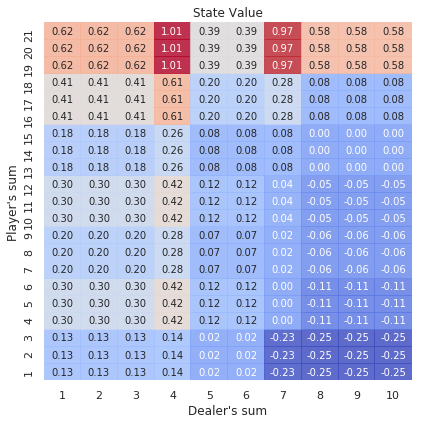

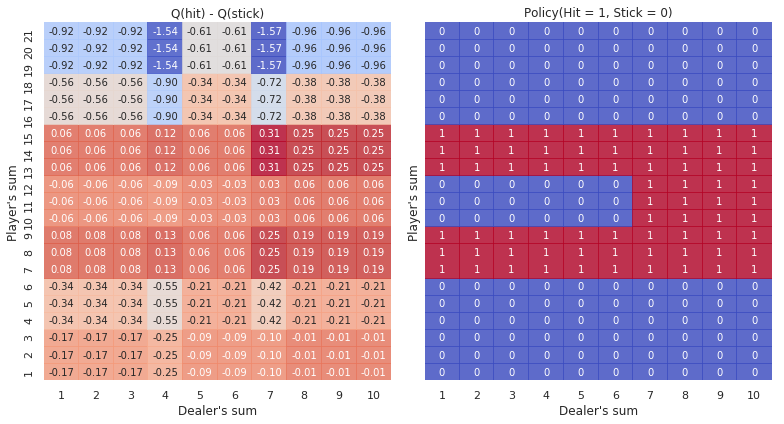

In [214]:
ls_mae_v, ls_mae_q, ls_match, ls_value, _ = evaluate_linear_model(theta_ls)

This does not look even a good linear model.  

Another way to define a good linear model by how often it leads to the optimal policy.
We can find the "best" in this way by fitting logistic regression model to predict the action.  Notice that coefficient of the logistic regression corresponds to the $\theta$ for action 1 ("HIT") and $\theta$ for action 0 ("STICK") is assumed to be zeros. This is because logistic regression only cares about the decision to be made; The coefficients are only meaningful by the relative differences, and thus one class is used as anchor with zero coefficients.

MAE of state values      = 1.07216
MAE of action values     = 0.93318
Fraction of policy match = 88.57%
Expected player value    = 0.03966


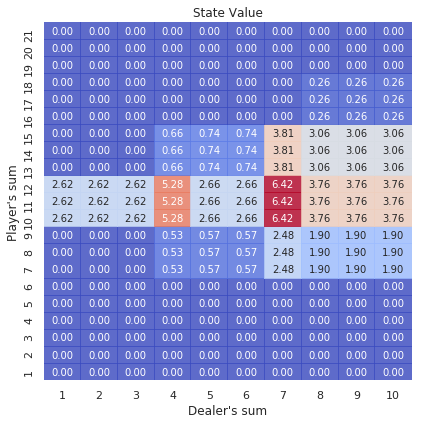

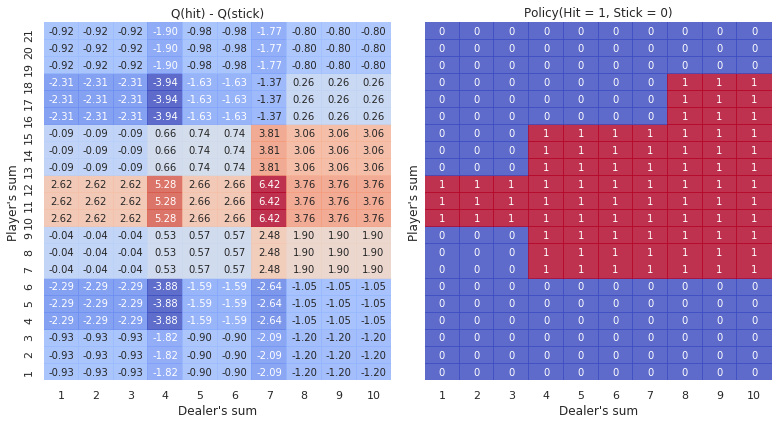

In [215]:
y_ = policy_dp.reshape(-1)
model = LogisticRegression(solver='lbfgs')
model.fit(x_, y_)

theta_logit = np.zeros((18, 2))
theta_logit[:, 1] = model.coef_
theta_logit
logit_mae_v, logit_mae_q, logit_match, logit_value, _ = evaluate_linear_model(theta_logit)

By focusing only on the policy estimate, we got much nicer fit to the predicted policy, while value estimates are at best understood by the relative positions.

This approach has its own drawback: It weights mistakes at every state equally.  
Taking a suboptimal action can be disastorous at some states, while not a big deal at others.  Logistic regression overlooks such differences across states.

In this case, logit estimates gets slightly better mean value than the least squares estimates.

Probably, the appropriate approach to find the "best" linear approximation is to solve for the **dynamic programming with linear approximation** (not tried here).  

## Evaluate linear Sarsa

In [216]:
theta = np.zeros((18, 2))
mae_vs = []
mae_qs = []
fracs = []
values = []
for i in tqdm(range(10**6)):
    linear_sarsa_episode(env, theta, epsilon_greedy_policy, alpha, gamma)
    if (i+1) % 1000 == 0:
        mae_v, mae_q, frac, value_, _ = evaluate_linear_model(theta, plot=False, message=False)
        mae_vs.append(mae_v)
        mae_qs.append(mae_q)
        fracs.append(frac)
        values.append(value_)

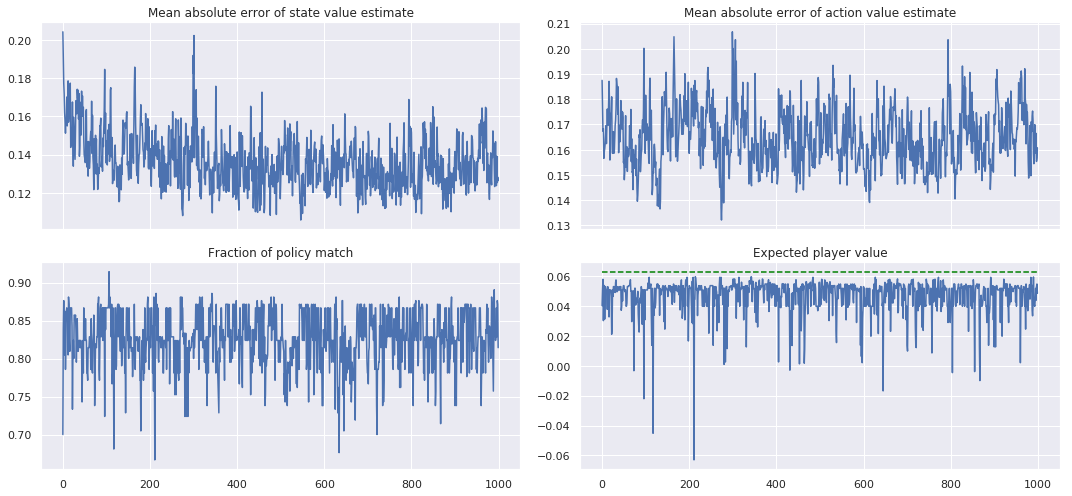

In [218]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharex=True)
axes[0][0].plot(mae_vs)
axes[0][1].plot(mae_qs)
axes[1][0].plot(fracs)
axes[1][1].plot(values)
axes[1][1].hlines(mean_value_dp, 0, len(values), linestyles="--", color="green")
axes[0][0].set_title("Mean absolute error of state value estimate")
axes[0][1].set_title("Mean absolute error of action value estimate")
axes[1][0].set_title("Fraction of policy match")
axes[1][1].set_title("Expected player value")
fig.tight_layout()
None

MAE of state values      = 0.12643
MAE of action values     = 0.16077
Fraction of policy match = 81.43%
Expected player value    = 0.04850


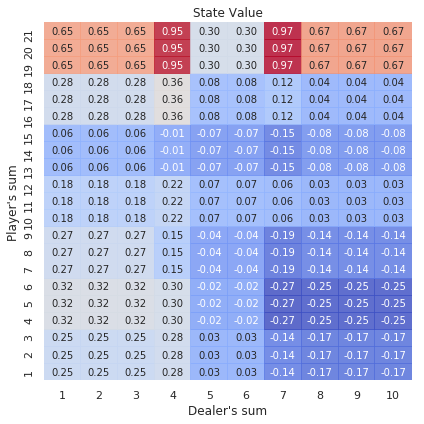

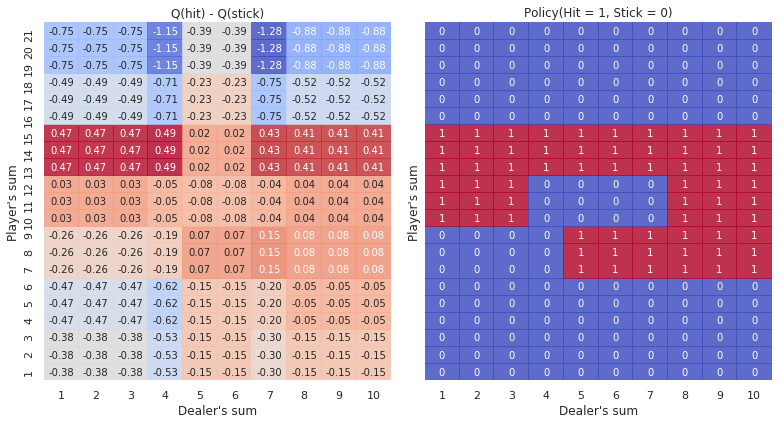

In [219]:
evaluate_linear_model(theta)
None

## Linear Q-learning

1. Initialize $\theta$.
1. Set $t=0$ and initialize $s_t$.
1. Choose $a_t$ from exploration policy for $s_t$.
1. Take action $a_t$ and obtain $(r_{t+1}, s_{t+1})$.
1. Compute $\delta_t \leftarrow r_{t+1} + \gamma \max_a \left( \phi(s_{t+1}, a) \cdot \theta \right) - \phi(s_{t}, a_{t}) \cdot \theta$
1. Update $\theta$ by
$$\theta \leftarrow \theta + \alpha \delta_t \phi(s, a)$$
1. If $s_{t+1}$ is not terminal, set $t \leftarrow t+1$ and go to 3.
1. Finish if maximum number of iteration has reached, otherwise go to 2.

In [222]:
def linear_qlearn_episode(env, theta, exploration_policy, alpha, gamma):
    s = env.reset()
    
    while True:
        idx = active_features(s)
        qs = np.sum(theta[idx], axis=0)
        a = epsilon_greedy_policy(qs)
        s1, r, done, _ = env.step(a)
        
        if done:
            delta = r - qs[a]
            theta[idx, a] += alpha * delta
            break
        else:
            idx1 = active_features(s1)
            qs1 = np.sum(theta[idx1], axis=0)
            delta = r + gamma * np.max(qs1) - qs[a]
            theta[idx, a] += alpha * delta
            s = s1

In [223]:
theta = np.zeros((18, 2))
mae_vs = []
mae_qs = []
fracs = []
values = []
for i in tqdm(range(10**6)):
    linear_qlearn_episode(env, theta, epsilon_greedy_policy, alpha, gamma)
    if (i+1) % 1000 == 0:
        mae_v, mae_q, frac, value_, _ = evaluate_linear_model(theta, plot=False, message=False)
        mae_vs.append(mae_v)
        mae_qs.append(mae_q)
        fracs.append(frac)
        values.append(value_)

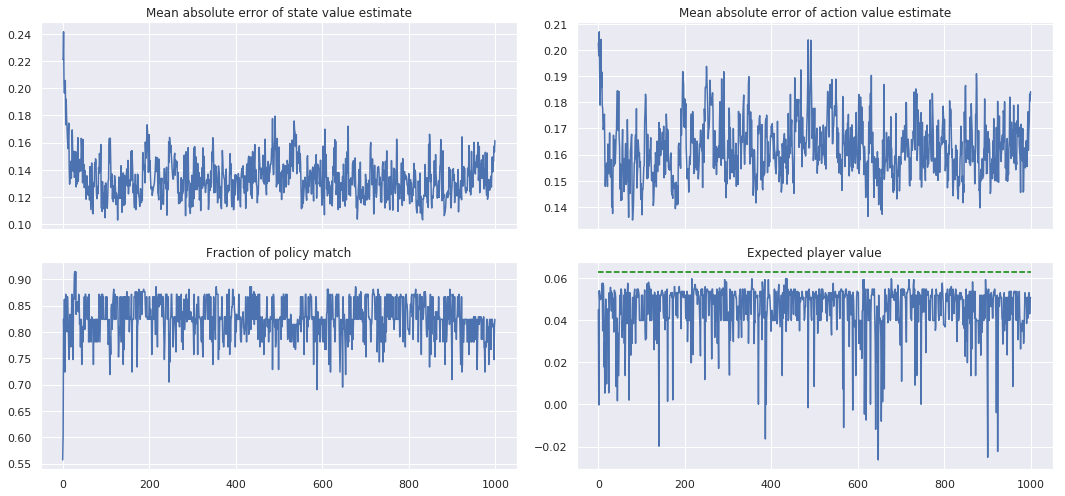

In [224]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharex=True)
axes[0][0].plot(mae_vs)
axes[0][1].plot(mae_qs)
axes[1][0].plot(fracs)
axes[1][1].plot(values)
axes[1][1].hlines(mean_value_dp, 0, len(values), linestyles="--", color="green")
axes[0][0].set_title("Mean absolute error of state value estimate")
axes[0][1].set_title("Mean absolute error of action value estimate")
axes[1][0].set_title("Fraction of policy match")
axes[1][1].set_title("Expected player value")
fig.tight_layout()
None

MAE of state values      = 0.16157
MAE of action values     = 0.18408
Fraction of policy match = 82.38%
Expected player value    = 0.05079


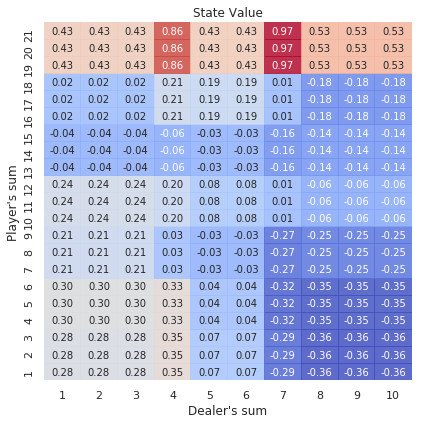

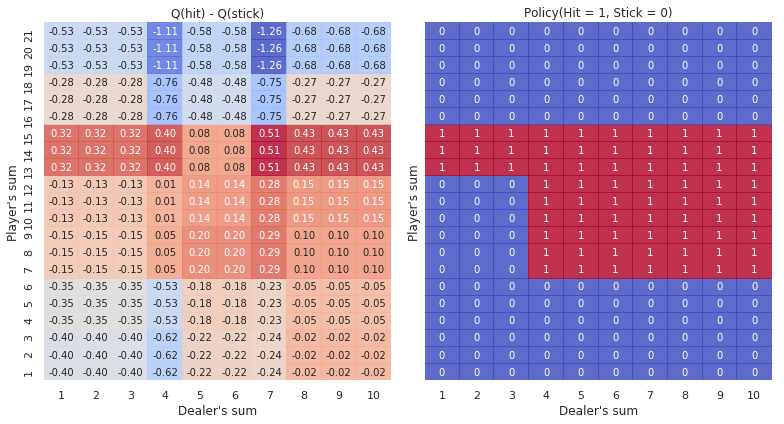

In [225]:
evaluate_linear_model(theta)
None

*Remark: Q-learning seems slightly better than Sarsa.*